# Spot Detection
```{eval-rst}
Last updated |lastupdate|
```

[![Open in Colab](https://img.shields.io/static/v1?logo=google-colab&message=Open%20in%20colab&color=blue&label=%20&labelColor=5c5c5c)](https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/spot-detection.ipynb)

In this section we will build a model that will detect beetle appendages in images of beetles. The training data is courtesy of the Parker lab at Caltech. The images of ants are annotated with coordinates for different types of appendages (head, abdomen, thorax, etc.) 

In [4]:
!pip install tensorflow-addons "deepcell==0.9.0"

     |████████████████████████████████| 706kB 4.5MB/s 
     |████████████████████████████████| 122kB 9.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 37.6MB 86kB/s 
  Created wheel for deepcell: filename=DeepCell-0.9.0-cp37-none-any.whl size=210482 sha256=b6894858ccf76bda357c24c3f73776e4dade14bb2b6c9150476943b9bfb53999
  Stored in directory: /root/.cache/pip/wheels/3d/68/e3/3821ee7bf074d9e652ed16d8e1a3a52337cc319eca51bb2215
  Created wheel for deepcell-toolbox: filename=Deepcell_Toolbox-0.9.0-cp37-cp37m-linux_x86_64.whl size=169729 sha256=e1510e9bcfc5c21030559f3840dd92548b11bfbd53ae88ccd88f391121b68b67
  Stored in directory: /root/.cache/pip/wheels/72/2d/de/c61b47be8620fc1d3f06a8379ab939897776a14b4834416603
Successfully built deepcell dee

In [5]:
import os
import glob
import imageio
import skimage
import skimage.exposure
import skimage.transform
import copy
import re

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.model_selection
from tqdm.notebook import tqdm

To solve this problem, we will treat it as a regression problem. For each image we will try to predict a transform image. This transform image will tell us how far each pixel is from the nearest spot. By looking for the extrema in the predicted transform image, we will be able to identify the appendages.

The transform we will use is 
\begin{equation}
transform = \frac{1}{1+\frac{distance}{\alpha}},
\end{equation}
where $\alpha$ is a parameter that determines the length scale. We will set $\alpha$ to be ~10 pixels, which is roughly the length scale for an appendage.

## Load data

In [1]:
!wget https://storage.googleapis.com/datasets-spring2021/bugs.npz
!wget https://storage.googleapis.com/datasets-spring2021/bug_annotations.csv

--2021-04-27 20:50:36--  https://storage.googleapis.com/datasets-spring2021/bugs.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150569685 (144M) [application/octet-stream]
Saving to: ‘bugs.npz’

bugs.npz            100%[===================>] 143.59M   122MB/s    in 1.2s    

2021-04-27 20:50:38 (122 MB/s) - ‘bugs.npz’ saved [150569685/150569685]

--2021-04-27 20:50:38--  https://storage.googleapis.com/datasets-spring2021/bug_annotations.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 726875 (710K) [text/csv]
Saving to: ‘bug_annotations.csv’

bug

In [6]:
# Load data and convert annotations to transform images
from scipy.ndimage.morphology import distance_transform_edt

# We will compute the transforms for each set of annotations using the 
# coord_to_dist function
def coord_to_dist(point_list,
                  image_shape=(512,512),
                  alpha=10,
                  dy=1,
                  dx=1):
    # create an image with 0 = pixel containing point 
    # from point_list, 1 = pixel not containing point from point_list
    contains_point = np.ones(image_shape) 

    for ind, [x, y] in enumerate(point_list):
        nearest_pixel_y_ind = int(round(y/dy))
        nearest_pixel_x_ind = int(round(x/dx))
        contains_point[nearest_pixel_y_ind, nearest_pixel_x_ind] = 0

    edt, inds = distance_transform_edt(contains_point, return_indices=True, sampling=[dy, dx])
    transform = 1/(1+edt/alpha)
    
    return transform

def load_bug_data():
    bugs_path = 'bugs.npz'
    csv_path = 'bug_annotations.csv'

    bug_file = np.load(bugs_path)
    bug_imgs = bug_file['X'].astype('float')
    bug_imgs /= 255.0
    
    print(bug_imgs.shape)
    # Normalize bug images
    bug_imgs_norm = []
    for i in tqdm(range(bug_imgs.shape[0])):
        img = bug_imgs[i,...]
        img = skimage.exposure.equalize_adapthist(img)
        img = skimage.exposure.rescale_intensity(img, out_range=(0,1))
        img = skimage.transform.resize(img, (256,256))
        bug_imgs_norm.append(img)
    bug_imgs = np.stack(bug_imgs_norm, axis=0)
    bug_imgs = np.expand_dims(bug_imgs, axis=-1)

    # Load annotations
    csv_df = pd.read_csv(csv_path)
    csv_df.head()

    head_list = []
    thorax_list = []
    abdomen_list = []

    # Convert point_lists to transform images
    for i in tqdm(range(bug_imgs.shape[0])):
        # Load the annotation for the image
        ann = csv_df.loc[csv_df['fileindex']==i]
        head_ann = ann.loc[ann['bodyparts']=='head'][['x', 'y']] * 256/500
        thorax_ann = ann.loc[ann['bodyparts']=='thorax'][['x', 'y']] * 256/500
        abdomen_ann = ann.loc[ann['bodyparts']=='abdomen'][['x', 'y']] * 256/500

        head_ann = np.array(head_ann)
        thorax_ann = np.array(thorax_ann)
        abdomen_ann = np.array(abdomen_ann)

        # Compute transforms
        head_distance_img = coord_to_dist(head_ann, image_shape=(256,256))
        thorax_distance_img = coord_to_dist(thorax_ann, image_shape=(256,256))
        abdomen_distance_img = coord_to_dist(abdomen_ann, image_shape=(256,256))

        head_list.append(head_distance_img)
        thorax_list.append(thorax_distance_img)
        abdomen_list.append(abdomen_distance_img)

    head_distance = np.stack(head_list, axis=0)
    thorax_distance = np.stack(thorax_list, axis=0)
    abdomen_distance = np.stack(abdomen_list, axis=0)
    
    head_distance = np.expand_dims(head_distance, axis=-1)
    thorax_distance = np.expand_dims(thorax_distance, axis=-1)
    abdomen_distance = np.expand_dims(abdomen_distance, axis=-1)
    
    return bug_imgs, head_distance, thorax_distance, abdomen_distance

bug_imgs, head_distance, thorax_distance, abdomen_distance = load_bug_data()

(847, 500, 500)


(847, 256, 256, 1)


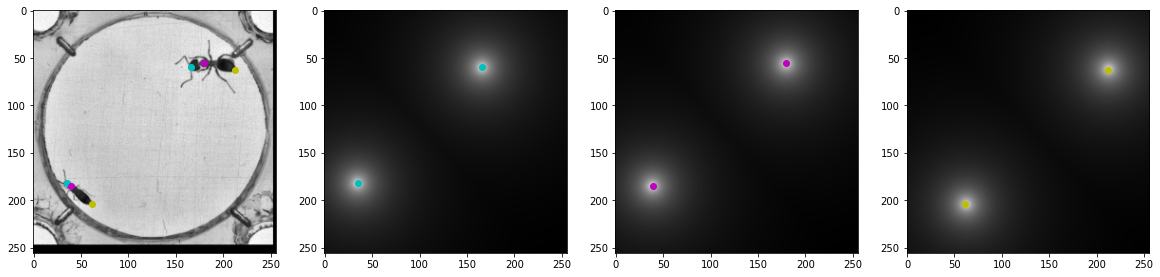

In [ ]:
# Visually inspect the images and transforms to make sure they are correct
print(bug_imgs.shape)
csv_path = 'bug_annotations.csv'
csv_df = pd.read_csv(csv_path)

fig, axes = plt.subplots(1,4,figsize=(20,20))

index = 0
ann = csv_df.loc[csv_df['fileindex']==index]
head_ann = np.array(ann.loc[ann['bodyparts']=='head'][['y', 'x']]) * 256/500
thorax_ann = np.array(ann.loc[ann['bodyparts']=='thorax'][['y', 'x']]) * 256/500
abdomen_ann = np.array(ann.loc[ann['bodyparts']=='abdomen'][['y', 'x']]) * 256/500

axes[0].imshow(bug_imgs[index,...], cmap='gray')
axes[0].scatter(head_ann[:,1], head_ann[:,0], color='c')
axes[0].scatter(thorax_ann[:,1], thorax_ann[:,0], color='m')
axes[0].scatter(abdomen_ann[:,1], abdomen_ann[:,0], color='y')

axes[1].imshow(head_distance[index,:,:], cmap='gray')
axes[1].scatter(head_ann[:,1], head_ann[:,0], color='c')

axes[2].imshow(thorax_distance[index,:,:], cmap='gray')
axes[2].scatter(thorax_ann[:,1], thorax_ann[:,0], color='m')

axes[3].imshow(abdomen_distance[index,:,:], cmap='gray')
axes[3].scatter(abdomen_ann[:,1], abdomen_ann[:,0], color='y')

## Prepare dataset object

Creating the dataset object is more challenging for this problem due to our problem framing. Because we are predicting the transform images, we need to make sure we apply the same transform to the raw image and the transform images. If we do not, then the information content of the transform images (e.g., where the appendages are) will be lost.

Doing this using tensorflow dataset objects is a little challenging. We will need to specify the augmentation operation that will be applied, and then specifically apply it to each of image (e.g., the raw image and each of the transform images). To specify the augmentation operation, we will need to specify the transform matrix. Moreover, this specification needs to be done with tensorflow objects (e.g., tensorflow tensors and operations from tf.image). These steps are executed in the following cell.

An additional practical programming note - because we are predicting 3 transforms, we will need a network that produces 3 prediction images. It can get confusing to keep track of which prediction image is which. To mitigate this, we will have our dataset object produce dictionaries rather than tuples or lists. The key names in the dictionary will match the names of the corresponding layers in the deep learning model. This will help us keep track of which transform image is which and what part of the model it should be paired with.

In [ ]:
# Create dataset object

class BugDatasetBuilder(object):
    def __init__(self,
                 X,
                 y_head,
                 y_abdomen,
                 y_thorax,
                 batch_size=1,
                 augmentation_kwargs={'zoom_range':(0.75, 1.25),
                                      'horizontal_flip': True,
                                      'vertical_flip': True,
                                      'rotation_range': 180}):
        self.X = X.astype('float32')
        self.y_head = y_head.astype('float32')
        self.y_abdomen = y_abdomen.astype('float32')
        self.y_thorax = y_thorax.astype('float32')
        
        self.batch_size = batch_size
        self.augmentation_kwargs = augmentation_kwargs
        
        # Create dataset
        self._create_dataset()
        
    def _transform_matrix_offset_center(self, matrix, x, y):
        o_x = float(x) / 2 + 0.5
        o_y = float(y) / 2 + 0.5
        offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]], dtype='float32')
        reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]], dtype='float32')
        
        offset_matrix = tf.convert_to_tensor(offset_matrix)
        reset_matrix = tf.convert_to_tensor(reset_matrix)
        
        transform_matrix = tf.keras.backend.dot(tf.keras.backend.dot(offset_matrix, matrix), reset_matrix)
        return transform_matrix
        
    def _compute_random_transform_matrix(self):
        rotation_range = self.augmentation_kwargs['rotation_range']
        zoom_range = self.augmentation_kwargs['zoom_range']
        horizontal_flip = self.augmentation_kwargs['horizontal_flip']
        vertical_flip = self.augmentation_kwargs['vertical_flip']
        
        
        # Get random angles
        theta = tf.random.uniform(shape=(1,), 
                                  minval=-np.pi*rotation_range/180, 
                                  maxval=np.pi*rotation_range/180)
        one = tf.constant(1.0, shape=(1,))
        zero = tf.constant(0.0, shape=(1,))
        cos_theta = tf.math.cos(theta)
        sin_theta = tf.math.sin(theta)
        
        rot_row_0 = tf.stack([cos_theta, -sin_theta, zero], axis=1)
        rot_row_1 = tf.stack([sin_theta, cos_theta, zero], axis=1)
        rot_row_2 = tf.stack([zero, zero, one], axis=1)
        rotation_matrix = tf.concat([rot_row_0, rot_row_1, rot_row_2], axis=0)
        
        transform_matrix = rotation_matrix
        
        # Get random lr flips
        lr = 2*tf.cast(tf.random.categorical(tf.math.log([[0.5, 0.5]]), 1), 'float32')[0] - 1.0
        lr_row_0 = tf.stack([lr, zero, zero], axis=1)
        lr_row_1 = tf.stack([zero, one, zero], axis=1)
        lr_row_2 = tf.stack([zero, zero, one], axis=1)
        lr_flip_matrix = tf.concat([lr_row_0, lr_row_1, lr_row_2], axis=0)
        
        transform_matrix = tf.keras.backend.dot(transform_matrix, lr_flip_matrix)
        
        # Get randum ud flips
        ud = 2*tf.cast(tf.random.categorical(tf.math.log([[0.5, 0.5]]), 1), 'float32')[0] - 1.0
        ud_row_0 = tf.stack([one, zero, zero], axis=1)
        ud_row_1 = tf.stack([zero, ud, zero], axis=1)
        ud_row_2 = tf.stack([zero, zero, one], axis=1)
        ud_flip_matrix = tf.concat([ud_row_0, ud_row_1, ud_row_2], axis=0)
        
        transform_matrix = tf.keras.backend.dot(transform_matrix, ud_flip_matrix)

        # Get random zooms
        zx = tf.random.uniform(shape=(1,), minval=zoom_range[0], maxval=zoom_range[1])
        zy = tf.random.uniform(shape=(1,), minval=zoom_range[0], maxval=zoom_range[1])
        z_row_0 = tf.stack([zx, zero, zero], axis=1)
        z_row_1 = tf.stack([zero, zy, zero], axis=1)
        z_row_2 = tf.stack([zero, zero, one], axis=1)
        zoom_matrix = tf.concat([z_row_0, z_row_1, z_row_2], axis=0)
        
        transform_matrix = tf.keras.backend.dot(transform_matrix, zoom_matrix)

        # Combine all matrices
        h, w = self.X.shape[1], self.X.shape[2]
        transform_matrix = self._transform_matrix_offset_center(transform_matrix, h, w)
        return transform_matrix        
    
    def _augment(self, *args):
        X_dict = args[0]
        y_dict = args[1]
        
        # Compute random transform matrix    
        transform_matrix = self._compute_random_transform_matrix()
        transform_matrix = tf.reshape(transform_matrix, [1,-1])
        transform_matrix = transform_matrix[:,0:8]
        
        for key in X_dict:
            X_dict[key] = tfa.image.transform(X_dict[key],
                                              transform_matrix,
                                              interpolation = 'BILINEAR')
        for key in y_dict:
            interp = 'BILINEAR' if y_dict[key].shape[-1] == 1 else 'NEAREST'
            y_dict[key] = tfa.image.transform(y_dict[key],
                                    transform_matrix,
                                    interpolation = interp)
        return (X_dict, y_dict)
        
    def _create_dataset(self):
        X_train, X_temp, y_head_train, y_head_temp, y_abdomen_train, y_abdomen_temp, y_thorax_train, y_thorax_temp = sklearn.model_selection.train_test_split(self.X, self.y_head, self.y_abdomen, self.y_thorax, train_size=0.8)
        X_val, X_test, y_head_val, y_head_test, y_abdomen_val, y_abdomen_test, y_thorax_val, y_thorax_test = sklearn.model_selection.train_test_split(X_temp, y_head_temp, y_abdomen_temp, y_thorax_temp, train_size=0.5)
        
        X_train_dict = {'X': X_train}
        y_train_dict = {'head': y_head_train,
                        'abdomen': y_abdomen_train,
                        'thorax': y_thorax_train}
        
        X_val_dict = {'X': X_val}
        y_val_dict = {'head': y_head_val,
                      'abdomen': y_abdomen_val,
                      'thorax': y_thorax_val}
        
        X_test_dict = {'X': X_test}
        y_test_dict = {'head': y_head_test,
                       'abdomen': y_abdomen_test,
                       'thorax': y_thorax_test}
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_dict, y_train_dict))
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val_dict, y_val_dict))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test_dict, y_test_dict))
        
        self.train_dataset = train_dataset.shuffle(256).batch(self.batch_size).map(self._augment)
        self.val_dataset = val_dataset.batch(self.batch_size)
        self.test_dataset = test_dataset.batch(self.batch_size)

batch_size = 8
bug_data = BugDatasetBuilder(bug_imgs, head_distance, abdomen_distance, thorax_distance, batch_size=batch_size)

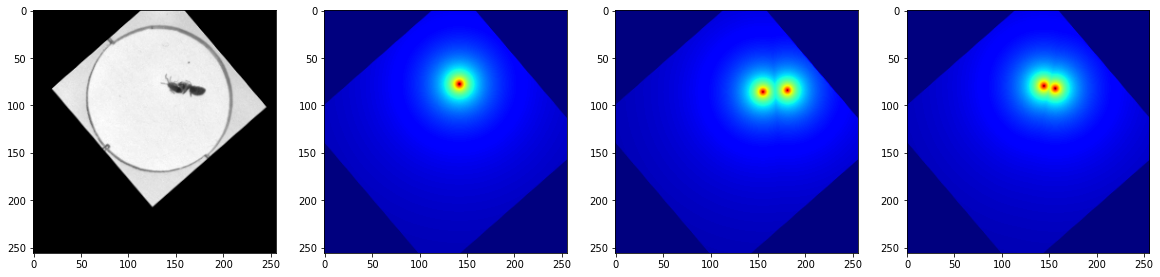

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20,20))

for i in range(4):
    X_dict, y_dict = next(iter(bug_data.train_dataset))
    axes[0].imshow(X_dict['X'][0,...], cmap='gray')
    axes[1].imshow(y_dict['head'][0,...], cmap='jet')
    axes[2].imshow(y_dict['abdomen'][0,...], cmap='jet')
    axes[3].imshow(y_dict['thorax'][0,...], cmap='jet')

## Prepare model

Next, we will need to make a model. Because we are doing image level prediction, our model choice also becomes a little more complicated. Our backbones will produce features at different scales, and we would like to use them to make dense, pixel level predictions. This requires us to both upsample feature maps and also integrate features across length scales. Lower level features contain fine spatial details while the higher level features contain contextual information - we would like to use both to make our prediction. While there are many approaches to doing so, the two most common are
- U-Nets: U-Nets upsample and concatenate to merge feature maps
- Feature pyramids: Feature pyramids upsample and add to merge feature maps
The accuracy for each approaches are often similar, but feature pyramids are often faster and require less memory.

The first step will be to extract the features from the backbone, which concretely means we need to extract the outputs of specific layers. See the [get_backbone](https://github.com/vanvalenlab/deepcell-tf/blob/master/deepcell/utils/backbone_utils.py) function from the deepcell-tf repository for a more general implementation.

In [ ]:
def get_backbone(backbone, input_tensor=None, input_shape=None,
                 use_imagenet=False, return_dict=True,
                 frames_per_batch=1, **kwargs):
    
    # Make sure backbone name is lower case
    _backbone = str(backbone).lower()
    
    # List of acceptable backbones
    resnet_backbones = {
        'resnet50': tf.keras.applications.resnet.ResNet50,
        'resnet101': tf.keras.applications.resnet.ResNet101,
        'resnet152': tf.keras.applications.resnet.ResNet152,
    }
    
    # Create the input for the model
    if input_tensor is not None:
        img_input = input_tensor
    else:
        if input_shape:
            img_input = Input(shape=input_shape)
        else:
            img_input = Input(shape=(None, None, 3))
    
    # Grab the weights if we're using a model pre-trained
    # on imagenet
    if use_imagenet:
        kwargs_with_weights = copy.copy(kwargs)
        kwargs_with_weights['weights'] = 'imagenet'
    else:
        kwargs['weights'] = None
        
    if _backbone in resnet_backbones:
        model_cls = resnet_backbones[_backbone]
        model = model_cls(input_tensor=img_input, **kwargs)

        # Set the weights of the model if requested
        if use_imagenet:
            model_with_weights = model_cls(**kwargs_with_weights)
            model_with_weights.save_weights('model_weights.h5')
            model.load_weights('model_weights.h5', by_name=True)

        # Define the names of the layers that have the desired features
        if _backbone == 'resnet50':
            layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out',
                           'conv4_block6_out', 'conv5_block3_out']
        elif _backbone == 'resnet101':
            layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out',
                           'conv4_block23_out', 'conv5_block3_out']
        elif _backbone == 'resnet152':
            layer_names = ['conv1_relu', 'conv2_block3_out', 'conv3_block8_out',
                           'conv4_block36_out', 'conv5_block3_out']
        
        # Get layer outputs
        layer_outputs = [model.get_layer(name=ln).output for ln in layer_names]
        
    else:
        raise ValueError('Invalid value for `backbone`')
        
    output_dict = {'C{}'.format(i + 1): j for i, j in enumerate(layer_outputs)}
    return (model, output_dict) if return_dict else model

With the ability to grab the features from the backbone, the next step is to merge features. Here, we will use a feature pyramid network.
![image.png](../images/feature-pyramid.png)
The recipe for how to merge a coarse and fine feature map is shown in the above figure. The coarse feature map is upsampled, while a 1x1 convolution is applied to the fine feature map. The result of each of these operations are then added together. This result is used as the "coarse" feature map for the next step of the pyramid. An implementation of functions to build feature pyramids starting from backbone features is the [create_pyramid_features](https://github.com/vanvalenlab/deepcell-tf/blob/master/deepcell/model_zoo/fpn.py) function in deepcell_tf.

Backbone features are typically described using the nomenclature C[n], where n denotes the backbone level. Level n denotes downsampling by $\frac{1}{2^n}$. For example, C3 backbone feature maps would have 1/8th the size of the input image. Feature pyramids typically use features from C3, C4, and C5. The pyramid features of the corresponding level are described as P[n]. The pyramid features derived from C3-C5 are typically P3-P7. Pyramid levels P6 and P7 are created with convolutions of stride 2 of the coarsest backbone feature map.

Note that the typical feature pyramid doesn't produce feature maps that are the same size of the original image (P3 is 1/8th the size of the input image) - this means we can't use them to make our pixel-level predictions. To produce correctly sized feature maps, we can upsample the top feature of the feature pyramid using a sequence of upsampling and convolution layers. We could also just add more pyramid levels (e.g. P2, P1, and P0), but this would be computationally more expensive. This sequence of upsampling and convolutions can be viewed as a separate submodel called a head. We can attach three of these heads to our feature pyramid - one for each prediction we hope to make (head, abdomen, and thorax).

In [ ]:
from deepcell.layers import ImageNormalization2D, Location2D
from deepcell.model_zoo.fpn import __create_pyramid_features
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Dense
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras import Model
from deepcell.utils.misc_utils import get_sorted_keys
from deepcell.model_zoo.fpn import semantic_upsample

def __create_semantic_head(pyramid_dict,
                           input_target=None,
                           n_classes=3,
                           n_filters=128,
                           n_dense=128,
                           semantic_id=0,
                           output_name='prediction_head',
                           include_top=False,
                           target_level=2,
                           upsample_type='upsampling2d',
                           interpolation='bilinear',
                           **kwargs):
    """Creates a semantic head from a feature pyramid network.
    Args:
        pyramid_dict (dict): Dictionary of pyramid names and features.
        input_target (tensor): Optional tensor with the input image.
        n_classes (int): The number of classes to be predicted.
        n_filters (int): The number of convolutional filters.
        n_dense (int): Number of dense filters.
        semantic_id (int): ID of the semantic head.
        ndim (int): The spatial dimensions of the input data.
            Must be either 2 or 3.
        include_top (bool): Whether to include the final layer of the model
        target_level (int): The level we need to reach. Performs
            2x upsampling until we're at the target level.
        upsample_type (str): Choice of upsampling layer to use from
            ``['upsamplelike', 'upsampling2d', 'upsampling3d']``.
        interpolation (str): Choice of interpolation mode for upsampling
            layers from ``['bilinear', 'nearest']``.
    Raises:
        ValueError: ``interpolation`` not in ``['bilinear', 'nearest']``
        ValueError: ``upsample_type`` not in
            ``['upsamplelike','upsampling2d', 'upsampling3d']``
    Returns:
        tensorflow.keras.Layer: The semantic segmentation head
    """

    # Check input to interpolation
    acceptable_interpolation = {'bilinear', 'nearest'}
    if interpolation not in acceptable_interpolation:
        raise ValueError('Interpolation mode "{}" not supported. '
                         'Choose from {}.'.format(
                             interpolation, list(acceptable_interpolation)))

    # Check input to upsample_type
    acceptable_upsample = {'upsamplelike', 'upsampling2d', 'upsampling3d'}
    if upsample_type not in acceptable_upsample:
        raise ValueError('Upsample method "{}" not supported. '
                         'Choose from {}.'.format(
                             upsample_type, list(acceptable_upsample)))

    # Check that there is an input_target if upsamplelike is used
    if upsample_type == 'upsamplelike' and input_target is None:
        raise ValueError('upsamplelike requires an input_target.')

    conv = Conv2D 
    conv_kernel = (1,1)
    channel_axis = -1

    if n_classes == 1:
        include_top = False

    # Get pyramid names and features into list form
    pyramid_names = get_sorted_keys(pyramid_dict)
    pyramid_features = [pyramid_dict[name] for name in pyramid_names]

    # Reverse pyramid names and features
    pyramid_names.reverse()
    pyramid_features.reverse()

    x = pyramid_features[-1]

    # Perform upsampling
    n_upsample = target_level
    x = semantic_upsample(x, n_upsample,
                          target=input_target, ndim=2,
                          upsample_type=upsample_type, semantic_id=semantic_id,
                          interpolation=interpolation)

    x = Conv2D(n_dense, conv_kernel, strides=1, padding='same',
               name='conv_0_semantic_{}'.format(semantic_id))(x)
    x = BatchNormalization(axis=channel_axis,
                           name='batch_normalization_0_semantic_{}'.format(semantic_id))(x)
    x = Activation('relu', name='relu_0_semantic_{}'.format(semantic_id))(x)

    # Apply conv and softmax layer
    x = Conv2D(n_classes, conv_kernel, strides=1, padding='same', 
               name='conv_1_semantic_{}'.format(semantic_id))(x)

    if include_top:
        x = Softmax(axis=channel_axis,
                    dtype=K.floatx(),
                    name=output_name)(x)
    else:
        x = Activation('relu',
                       dtype=K.floatx(),
                       name=output_name)(x)

    return x

def BugModel(backbone='ResNet50',
             input_shape=(256,256,1),
             inputs=None,
             backbone_levels=['C3', 'C4', 'C5'],
             pyramid_levels=['P3', 'P4', 'P5', 'P6', 'P7'],
             create_pyramid_features=__create_pyramid_features,
             create_semantic_head=__create_semantic_head,
             required_channels=3,
             norm_method=None,
             pooling=None,
             location=True,
             use_imagenet=True,
             lite=False,
             upsample_type='upsampling2d',
             interpolation='bilinear',
             name='bug_model',
             **kwargs):
    
    if inputs is None:
        inputs = Input(shape=input_shape, name='X')
        
    # Normalize input images
    if norm_method is None:
        norm = inputs
    else:
        norm = ImageNormalization2D(norm_method=norm_method,
                                    name='norm')(inputs)
        
    # Add location layer - this breaks translational equivariance
    # but provides a notion of location to the model that can help
    # improve performance
    if location:
        loc = Location2D(name='location')(norm)
        concat = Concatenate(axis=-1,
                             name='concat_location')([norm, loc])
    else:
        concat = norm
        
    # Force the channel size for the backbone input to be 'required_channels'
    fixed_inputs = Conv2D(required_channels, (1,1), strides=1,
                        padding='same', name='conv_channels')(concat)

    # Force the input shape
    axis = -1
    fixed_input_shape = list(input_shape)
    fixed_input_shape[axis] = required_channels
    fixed_input_shape = tuple(fixed_input_shape)
    
    model_kwargs = {
        'include_top': False,
        'weights': None,
        'input_shape': fixed_input_shape,
        'pooling': pooling
    }

    # Get the backbone features
    _, backbone_dict = get_backbone(backbone, fixed_inputs,
                                    use_imagenet=use_imagenet,
                                    return_dict=True,
                                    **model_kwargs)

    backbone_dict_reduced = {k: backbone_dict[k] for k in backbone_dict
                             if k in backbone_levels}
    
    ndim = 2
    
    # Create the feature pyramid and get the relevant features
    pyramid_dict = create_pyramid_features(backbone_dict_reduced,
                                           ndim=ndim,
                                           lite=lite,
                                           interpolation=interpolation,
                                           upsample_type=upsample_type,
                                           z_axis_convolutions=False)

    features = [pyramid_dict[key] for key in pyramid_levels]
    
    # Figure out how much upsampling is required (e.g., if the top layer 
    # is P3, then a 8X upsample is required)
    semantic_levels = [int(re.findall(r'\d+', k)[0]) for k in pyramid_dict]
    target_level = min(semantic_levels)
    
    # Create the heads that perform upsampling to perform the final prediction
    prediction_head_list = []
    head_head = create_semantic_head(pyramid_dict, n_classes=1,
                                     input_target=inputs, target_level=target_level, semantic_id=0,
                                     output_name='head', ndim=ndim, upsample_type=upsample_type,
                                     interpolation=interpolation, **kwargs)
    abdomen_head = create_semantic_head(pyramid_dict, n_classes=1,
                                     input_target=inputs, target_level=target_level, semantic_id=1,
                                     output_name='abdomen', ndim=ndim, upsample_type=upsample_type,
                                     interpolation=interpolation, **kwargs)
    thorax_head = create_semantic_head(pyramid_dict, n_classes=1,
                                     input_target=inputs, target_level=target_level, semantic_id=2,
                                     output_name='thorax', ndim=ndim, upsample_type=upsample_type,
                                     interpolation=interpolation, **kwargs)
    outputs = [head_head, abdomen_head, thorax_head]
    
    model = Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [ ]:
bug_model = BugModel()
bug_model.summary()

Model: "bug_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
location (Location2D)           (None, None, None, 2 0           X[0][0]                          
__________________________________________________________________________________________________
concat_location (Concatenate)   (None, 256, 256, 3)  0           X[0][0]                          
                                                                 location[0][0]                   
__________________________________________________________________________________________________
conv_channels (Conv2D)          (None, 256, 256, 3)  12          concat_location[0][0]    

## Train Model

In [ ]:
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import SGD, Adam

# Define loss functions
loss = {}
for layer in bug_model.layers:
    if layer.name in ['head', 'abdomen', 'thorax']:
        loss[layer.name] = MSE
        
# Define training parameters
n_epochs = 16
lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)

# Compile model
bug_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
# Define callbacks
bug_model_path = '/notebooks/bebi205-sandbox/beetles/spot-detection-beetles.h5'

bug_callbacks = [tf.keras.callbacks.ModelCheckpoint(
                 bug_model_path, monitor='val_loss',
                 save_best_only=True, verbose=1,
                 save_weights_only=True)
                ]

bug_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(
                     monitor='val_loss', factor=0.5, verbose=1,
                     patience=3, min_lr=1e-7)
                     )

In [ ]:
# Train model
loss_history = bug_model.fit(bug_data.train_dataset,
                             validation_data=bug_data.val_dataset,
                             epochs=n_epochs,
                             verbose=1,
                             callbacks=bug_callbacks)

Epoch 1/16
85/85 [==============================] - 41s 293ms/step - loss: 0.1795 - head_loss: 0.0184 - abdomen_loss: 0.1233 - thorax_loss: 0.0378 - val_loss: 0.0633 - val_head_loss: 0.0210 - val_abdomen_loss: 0.0214 - val_thorax_loss: 0.0209

Epoch 00001: val_loss improved from inf to 0.06329, saving model to /notebooks/bebi205-sandbox/beetles/spot-detection-beetles.h5
Epoch 2/16
85/85 [==============================] - 22s 259ms/step - loss: 0.0092 - head_loss: 0.0033 - abdomen_loss: 0.0032 - thorax_loss: 0.0027 - val_loss: 0.0576 - val_head_loss: 0.0198 - val_abdomen_loss: 0.0183 - val_thorax_loss: 0.0195

Epoch 00002: val_loss improved from 0.06329 to 0.05757, saving model to /notebooks/bebi205-sandbox/beetles/spot-detection-beetles.h5
Epoch 3/16
85/85 [==============================] - 22s 260ms/step - loss: 0.0056 - head_loss: 0.0020 - abdomen_loss: 0.0019 - thorax_loss: 0.0017 - val_loss: 0.0507 - val_head_loss: 0.0161 - val_abdomen_loss: 0.0183 - val_thorax_loss: 0.0163

Epoch 

## Generate predictions

In [ ]:
test_iter = iter(bug_data.test_dataset)

[[163 156]
 [ 85 127]]
[[ 65 103]
 [143 163]]
[[159 158]
 [ 81 120]]


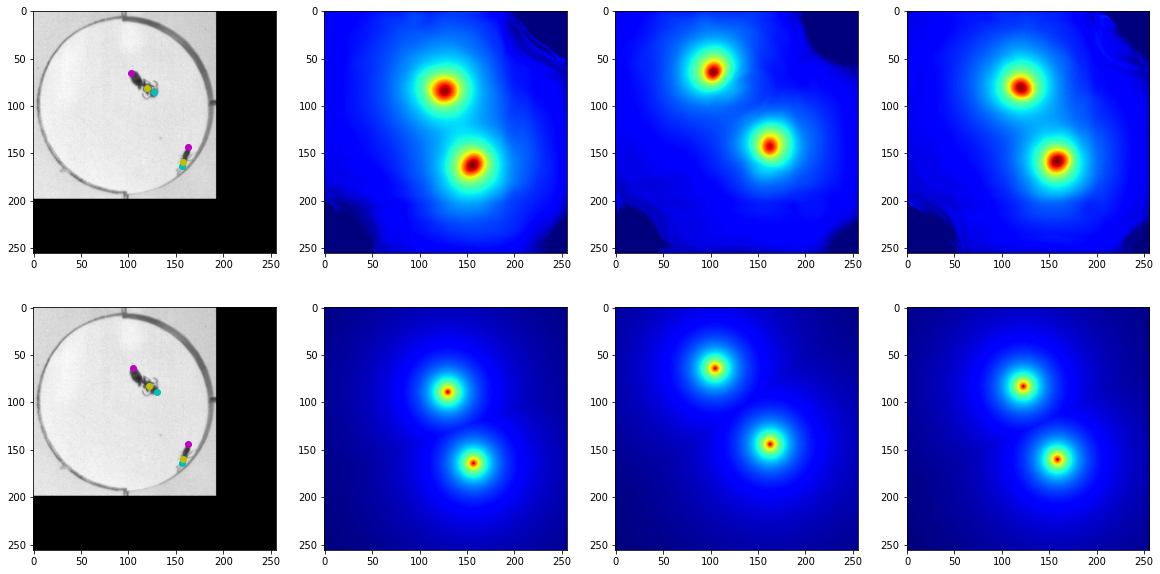

In [ ]:
# Visualize predictions
import scipy.ndimage as nd
from skimage.morphology import watershed, remove_small_objects, h_maxima, disk, square, dilation, local_maxima
from skimage.feature import peak_local_max

def post_processing(transform_img):
    max_list = []
    transform_img = transform_img[...,0]
    transform_img = nd.gaussian_filter(transform_img, 1)
    maxima = peak_local_max(image=transform_img,
                            min_distance=5,
                            threshold_abs=0.25,
                            exclude_border=False,
                            indices=True)

    return maxima
    

X_dict, y_true_dict = next(test_iter)
y_pred_list = bug_model.predict(X_dict)

head_markers = post_processing(y_pred_list[0][0,...])
abdomen_markers = post_processing(y_pred_list[1][0,...])
thorax_markers = post_processing(y_pred_list[2][0,...])

head_markers_true = post_processing(y_true_dict['head'][0,...])
abdomen_markers_true = post_processing(y_true_dict['abdomen'][0,...])
thorax_markers_true  = post_processing(y_true_dict['thorax'][0,...])

print(head_markers)
print(abdomen_markers)
print(thorax_markers)

y_pred_dict = {'head':y_pred_list[0],
               'abdomen':y_pred_list[1],
               'thorax':y_pred_list[2]}

fig, axes = plt.subplots(2,4, figsize=(20,10))

axes[0,0].imshow(X_dict['X'][0,...], cmap='gray')
axes[0,0].scatter(head_markers[:,1], head_markers[:,0], color='c')
axes[0,0].scatter(abdomen_markers[:,1], abdomen_markers[:,0], color='m')
axes[0,0].scatter(thorax_markers[:,1], thorax_markers[:,0], color='y')


axes[0,1].imshow(y_pred_dict['head'][0,...], cmap='jet')
axes[0,2].imshow(y_pred_dict['abdomen'][0,...], cmap='jet')
axes[0,3].imshow(y_pred_dict['thorax'][0,...], cmap='jet')

axes[1,0].imshow(X_dict['X'][0,...], cmap='gray')
axes[1,0].scatter(head_markers_true[:,1], head_markers_true[:,0], color='c')
axes[1,0].scatter(abdomen_markers_true[:,1], abdomen_markers_true[:,0], color='m')
axes[1,0].scatter(thorax_markers_true[:,1], thorax_markers_true[:,0], color='y')

axes[1,1].imshow(y_true_dict['head'][0,...], cmap='jet')
axes[1,2].imshow(y_true_dict['abdomen'][0,...], cmap='jet')
axes[1,3].imshow(y_true_dict['thorax'][0,...], cmap='jet')

## Benchmark model performance

Collect a set of samples from the test dataset in order to benchmark model performance.

In [ ]:
y_true, y_pred = [], []
for X_dict, y_true_dict in bug_data.test_dataset:
    y_pred_list = bug_model.predict(X_dict)
    
    # Extract predicted points
    y_pred.append(post_processing(y_pred_list[0][0,...]))
    y_pred.append(post_processing(y_pred_list[1][0,...]))
    y_pred.append(post_processing(y_pred_list[2][0,...]))

    # Extract true points from transformed images
    y_true.append(post_processing(y_true_dict['head'][0,...]))
    y_true.append(post_processing(y_true_dict['abdomen'][0,...]))
    y_true.append(post_processing(y_true_dict['thorax'][0,...]))
    
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [ ]:
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import scipy.spatial

def sum_of_min_distance(pts1, pts2, normalized=False):
    """Calculates the sum of minimal distance measure between two sets of d-dimensional points
    as suggested by Eiter and Mannila in:
    https://link.springer.com/article/10.1007/s002360050075
    Args:
       pts1 ((N1,d) numpy.array): set of N1 points in d dimensions
       pts2 ((N2,d) numpy.array): set of N2 points in d dimensions
           each row of pts1 and pts2 should be the coordinates of a single d-dimensional point
       normalized (bool): if true, each sum will be normalized by the number of elements in it,
           resulting in an intensive distance measure which doesn't scale like the number of points
    Returns:
        float: the sum of minimal distance between point sets X and Y, defined as:
        d(X,Y) = 1/2 * (sum over x in X of min on y in Y of d(x,y)
        + sum over y in Y of min on x in X of d(x,y))
        = 1/2( sum over x in X of d(x,Y) + sum over y in Y of d(X,y))
        where d(x,y) is the Euclidean distance
        Note that this isn't a metric in the mathematical sense (it doesn't satisfy the triangle
        inequality)
    """

    if len(pts1) == 0 or len(pts2) == 0:
        return np.inf

    # for each point in each of the sets, find its nearest neighbor from the other set
    tree1 = scipy.spatial.cKDTree(pts1, leafsize=2)
    dist21, _ = tree1.query(pts2)
    tree2 = scipy.spatial.cKDTree(pts2, leafsize=2)
    dist12, _ = tree2.query(pts1)

    if normalized:
        d_md = 0.5 * (np.mean(dist21) + np.mean(dist12))
    else:
        d_md = 0.5 * (np.sum(dist21) + np.sum(dist12))

    return d_md

def match_points_mutual_nearest_neighbor(pts1, pts2, threshold=None):
    '''Find a pairing between two sets of points that ensures that each pair of points are mutual nearest neighbors. 
    Args:
        pts1 ((N1,d) numpy.array): a set of N1 points in d dimensions
        pts2 ((N2,d) numpy.array): a set of N2 points in d dimensions
            where N1/N2 is the number of points and d is the dimension
        threshold (float): a distance threshold for matching two points. Points that are more than the threshold
        distance apart, cannot be matched
    Returns:
        row_ind, col_ind (arrays):
        An array of row indices and one of corresponding column indices giving the optimal assignment, as described in:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
    '''
    # calculate the distances between true points and their nearest predicted points
    # and the distances between predicted points and their nearest true points
    tree1 = scipy.spatial.cKDTree(pts1, leafsize=2)
    dist_to_nearest1, nearest_ind1 = tree1.query(pts2)
    # dist_to_nearest1[i] is the distance between pts1 point i and the pts2 point closest to it
    # nearest_ind1[i] is equal to j if pts1[j] is the nearest to pts2[i] from all of pts1
    tree2 = scipy.spatial.cKDTree(pts2, leafsize=2)
    dist_to_nearest2, nearest_ind2 = tree2.query(pts1)
    # dist_to_nearest2[i] is the distance between pts2 point i and the pts1 point nearest to it
    # nearest_ind2[i] is equal to j if pts2[j] is the nearest to pts1[i] from all of pts2

    # calculate the number of true positives
    pt_has_mutual_nn2 = nearest_ind2[nearest_ind1] == list(range(len(nearest_ind1)))
    pt_has_mutual_nn1 = nearest_ind1[nearest_ind2] == list(range(len(nearest_ind2)))
    if threshold is None:
        row_ind = np.where(pt_has_mutual_nn1)[0]
        col_ind = nearest_ind2[pt_has_mutual_nn1]

    else:
        pt_close_enough_to_nn1 = dist_to_nearest2 <= threshold
        matched_pts1 = pt_has_mutual_nn1 & pt_close_enough_to_nn1
        col_ind = nearest_ind2[matched_pts1]
        row_ind = np.where(matched_pts1)[0]

    return row_ind, col_ind


def point_precision(points_true, points_pred, threshold, match_points_function=match_points_mutual_nearest_neighbor):
    """ Calculates the precision, tp/(tp + fp), of point detection using the following definitions:
    true positive (tp) = a predicted dot p with a matching true dot t,
    where the matching between predicted and true points is such that the total distance between matched points is
    minimized, and points can be matched only if the distance between them is smaller than the threshold.
    Otherwise, the predicted dot is a false positive (fp).
    The precision is equal to (the number of true positives) / (total number of predicted points)
    Args:
        points_true ((N1,d) numpy.array): ground truth points for a single image
        points_pred ((N2,d) numpy.array): predicted points for a single image
            where N1/N2 is the number of points and d is the dimension
        threshold (float): a distance threshold used in the definition of tp and fp
        match_points_function: a function that matches points in two sets,
        and has three parameters: pts1, pts2, threshold -
        two sets of points, and a threshold distance for allowing a match
        supported matching functions are match_points_min_dist, match_points_mutual_nearest_neighbor
    Returns:
        float: the precision as defined above (a number between 0 and 1)
    """
    if len(points_true) == 0 or len(points_pred) == 0:
        return 0

    # find the minimal sum of distances matching between the points
    row_ind, col_ind = match_points_function(points_true, points_pred, threshold=threshold)

    # number of true positives = number of pairs matched
    tp = len(row_ind)

    precision = tp / len(points_pred)
    return precision


def point_recall(points_true, points_pred, threshold, match_points_function=match_points_mutual_nearest_neighbor):
    """Calculates the recall, tp/(tp + fn), of point detection using the following definitions:
    true positive (tp) = a predicted dot p with a matching true dot t,
    where the matching between predicted and true points is such that the total distance between matched points is
    minimized, and points can be matched only if the distance between them is smaller than the threshold.
    Otherwise, the predicted dot is a false positive (fp).
    The recall is equal to (the number of true positives) / (total number of true points)
    Args:
        points_true ((N1,d) numpy.array): ground truth points for a single image
        points_pred ((N2,d) numpy.array): predicted points for a single image
            where N1/N2 is the number of points and d is the dimension
        threshold (float): a distance threshold used in the definition of tp and fp
    Returns:
        float: the recall as defined above (a number between 0 and 1)
    """
    if len(points_true) == 0 or len(points_pred) == 0:
        return 0

    # find the minimal sum of distances matching between the points
    row_ind, col_ind = match_points_function(points_true, points_pred, threshold=threshold)

    # number of true positives = number of pairs matched
    tp = len(row_ind)

    recall = tp / len(points_true)
    return recall


def point_F1_score(points_true, points_pred, threshold, match_points_function=match_points_mutual_nearest_neighbor):
    """Calculates the F1 score of dot detection using the following definitions:
    F1 score = 2*p*r / (p+r)
    where
    p = precision = (the number of true positives) / (total number of predicted points)
    r = recall = (the number of true positives) / (total number of true points)
    and
    true positive (tp) = a predicted dot p with a matching true dot t,
    where the matching between predicted and true points is such that the total distance between matched points is
    minimized, and points can be matched only if the distance between them is smaller than the threshold.
    Otherwise, the predicted dot is a false positive (fp).
    Args:
        points_true ((N1,d) numpy.array): ground truth points for a single image
        points_pred ((N2,d) numpy.array): predicted points for a single image
            where N1/N2 is the number of points and d is the dimension
        threshold (float): a distance threshold used in the definition of tp and fp
    Returns:
        float: the F1 score as defined above (a number between 0 and 1)
    """
    p = point_precision(points_true, points_pred, threshold)
    r = point_recall(points_true, points_pred, threshold)
    if p == 0 or r == 0:
        return 0
    F1 = 2 * p * r / (p + r)
    return F1


def stats_points(points_true, points_pred, threshold, match_points_function=match_points_mutual_nearest_neighbor):
    """Calculates point-based statistics
    (precision, recall, F1, JAC, RMSE, d_md)
    Args:
        points_true ((N1,d) numpy.array): ground truth points for a single image
        points_pred ((N2,d) numpy.array): predicted points for a single image
            where N1/N2 is the number of points and d is the dimension
        threshold (float): a distance threshold used in the definition of tp and fp
    Returns:
        dictionary: containing the calculated statistics
    """

    # if one of the point sets is empty, precision=recall=0
    if len(points_true) == 0 or len(points_pred) == 0:
        p = 0
        r = 0
        F1 = 0
        J = 0
        RMSE = None
        dmd = None

        return {
            'precision': p,
            'recall': r,
            'F1': F1,
            'JAC': J,
            'RMSE': RMSE,
            'd_md': dmd
        }


    # find the minimal sum of distances matching between the points
    row_ind, col_ind = match_points_function(points_true, points_pred, threshold=threshold)

    # number of true positives = number of pairs matched
    tp = len(row_ind)

    p = tp / len(points_pred)
    r = tp / len(points_true)

    # calculate the F1 score from the precision and the recall
    if p == 0 or r == 0:
        F1 = 0
    else:
        F1 = 2*p*r / (p+r)

    # calculate the Jaccard index from the F1 score
    J = F1 / (2 - F1)

    # calculate the RMSE for matched pairs
    if len(row_ind) == 0:
        RMSE = None
        d_md = None
    else:
        dist_sq_sum = np.sum(np.sum((points_true[row_ind] - points_pred[col_ind]) ** 2, axis=1))
        RMSE = np.sqrt(dist_sq_sum/len(row_ind)/2)

        # RMSE = np.sqrt(mean_squared_error(points_true[row_ind], points_pred[col_ind]))

        # calculate the mean sum to nearest neighbor from other set
        d_md = sum_of_min_distance(points_true[row_ind], points_pred[col_ind], normalized=True)

    return {
        'precision': p,
        'recall': r,
        'F1': F1,
        'Jaccard Index': J,
        'Root Mean Squared Error': RMSE,
        'Average Distance': d_md
    }

In [ ]:
stats_points(y_true, y_pred, 20)

{'precision': 0.9361702127659575,
 'recall': 0.7457627118644068,
 'F1': 0.8301886792452831,
 'Jaccard Index': 0.7096774193548387,
 'Root Mean Squared Error': 1.8799177931736561,
 'Average Distance': 2.241467514540121}

---

In [ ]:
%load_ext watermark
%watermark -u -d -vm --iversions

re                2.2.1
pandas            1.1.5
skimage           0.17.2
numpy             1.19.5
tensorflow_addons 0.12.1
scipy.ndimage     2.0
tensorflow        2.4.1
sklearn           0.24.1
imageio           2.9.0
last updated: 2021-04-27 

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-142-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 24
interpreter: 64bit
